## 第二章 建模仿真原理：奶茶问题（Part 2）

### 奶茶问题（Part 2）

##### 问题描述：
假设我在家泡了杯热茶，还带了杯从冰箱里拿出来的牛奶，开车去上班，我希望上班的时候能喝上热奶茶。那我是在家出发的时候把牛奶倒进热茶里，还是在开车上班的途中某个时间点把牛奶倒进热茶里呢？

##### 一些假设：
1.刚泡的热茶温度为90摄氏度，有300mL。

2.牛奶从冰箱里拿出来的温度为5摄氏度，有50mL。

3.车里的环境温度为22摄氏度。

4.茶泡在保温杯里，从家到单位路程为30分钟，茶的温度降到了70摄氏度。

5.牛奶瓶不保温，15分钟后就会升温到20摄氏度，接近车内环境温度。

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

引用上一个笔记本的代码

In [2]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

In [3]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [4]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

### 热茶和牛奶的最佳混合时间
前面我们对热茶的冷却过程进行了模拟，一般情况下，我们并不知道参数r的取值，但我们能通过测量估计出它的值。给定一个初始温度，一个最终温度，以及间隔的时间，我们能通过尝试，找出r值。
下面我们使用一种更好的方法来找出r值，我们采用二分法搜索。
我们使用的ModSim库当中有个函数root_bisect就是用来搜索非线性方程的根。举一个简单的例子，假设我们要求解如下多项式的根：
$$f(x)=(x-1)(x-2)(x-3)$$
我们可以写一个函数：

In [5]:
def func(x):
    return (x-1) * (x-2) * (x-3)

root_bisect函数的第一个参数是待求解的函数，第二个参数是根所在的区域。

In [6]:
res = root_bisect(func, [0.5, 1.5])
res.root

1.0

如果我们给定另外一个求解区域，会得到另一个解。

In [7]:
res = root_bisect(func, [1.5, 2.5])
res.root

2.0

我们想要找到最终温度为70摄氏度时对应的$r$，所以我们定义了一个误差函数，以$r$作为输入参数，输出是70摄氏度和最终温度的差值。

In [8]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r=r, volume=300, t_end=30)
    results = run_simulation(system, update_func)
    T_final = get_last_value(results.T)
    return T_final - 70

选取$r=0.01$，我们发现茶有点热。

In [9]:
error_func1(r=0.01)

2.2996253904030937

选取$r=0.02$，我们发现茶有点凉。

In [10]:
error_func1(r=0.02)

-10.907066281994297

使用root_bisect求解70摄氏度对应的$r$值。

In [11]:
res = root_bisect(error_func1, [0.01, 0.02])
r_tea = res.root

0.011543084681034089

如果用估计的$r$值来运行仿真，可以看到最终温度为70度。

In [12]:
tea = make_system(T_init=90, r=r_tea, volume=300, t_end=30)
results = run_simulation(tea, update_func)
T_final = get_last_value(results.T)

69.99999985860761

### 练习
重复以上的过程，估计$r_{milk}$值。牛奶温度初始为5摄氏度，在15分钟之后达到20摄氏度。
在你使用root_bisect函数之前，可以先用试凑的方法，看看能够估计得多接近。以下程序帮助你开始这个过程：

In [13]:
r_milk = 0.1
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=15)
results = run_simulation(milk, update_func)
T_final = get_last_value(results.T)

18.499850754390966

# Solution goes here




### 混合液体
下面这个函数表示将两种液体混合的过程，计算混合液体的温度。输入两种待混合液体的System对象，输出为混合后液体的System对象。

In [14]:
def mix(system1, system2):
    """Simulates the mixture of two liquids.
    
    system1: System representing coffee
    system2: System representing milk
    
    returns: System representing the mixture
    """
    assert system1.t_end == system2.t_end
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.temp, system2.temp
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       r=system1.r,
                       volume=V_mix,
                       t_end=30)

mix函数需要System对象有temp这个系统变量。make_system函数初始化这个变量；随后的函数保证当我们运行仿真的时候能够不断更新它。

In [15]:
def run_and_set(system):
    """Run a simulation and set the final temperature.
    
    system: System
    
    returns: TimeFrame
    """
    results = run_simulation(system, update_func)
    system.temp = get_last_value(results.T)
    return results

### 立即混合
下一步我们仿真在上班前在热茶中立即倒入牛奶去上班的这种情况。

In [16]:
tea = make_system(T_init=90, r=r_tea, volume=300, t_end=30)
tea.temp

90

In [17]:
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=30)
milk.temp

5

In [18]:
mix_first = mix(tea, milk)
mix_first.temp

77.85714285714286

In [19]:
mix_results = run_and_set(mix_first)
mix_first.temp

61.4285713124277

### 最后混合
然后我们会看在到达上班地点后再混合奶茶的情况。我们将分别对热茶和牛奶进行仿真。

In [20]:
tea_results = run_and_set(tea)
tea.temp

69.99999985860761

In [21]:
milk_results = run_and_set(milk)
milk.temp

21.279350309321327

下图是看起来的冷却结果。

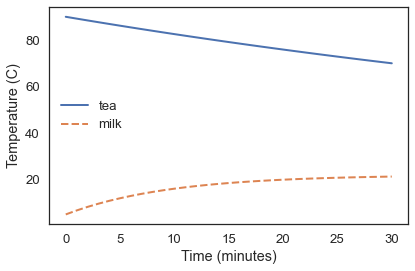

In [22]:
plot(tea_results.T, label='tea')
plot(milk_results.T, '--', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

当我们混合热茶和牛奶，看看温度怎么样。

In [23]:
mix_last = mix(tea, milk)
mix_last.temp

63.039907065852425

In [24]:
mix_last.temp - mix_first.temp

1.6113357534247257

有没有可能在30分钟的某个时间点混合是最佳的呢？

为了找到这个结果，我们编写下面的函数，以牛奶加入时间作为输入变量，返回最终温度。

In [25]:
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    tea = make_system(T_init=90, r=r_tea, volume=300, t_end=t_add)
    tea_results = run_and_set(tea)
    
    milk = make_system(T_init=5, r=r_milk, volume=50, t_end=t_add)
    milk_results = run_and_set(milk)
    
    mixture = mix(tea, milk)
    mixture.t_end = t_total - t_add
    results = run_and_set(mixture)

    return mixture.temp

我们尝试一些混合时间

In [26]:
run_and_mix(t_add=0, t_total=30)

61.4285713124277

In [27]:
run_and_mix(t_add=15, t_total=30)

62.722755084017976

In [28]:
run_and_mix(t_add=30, t_total=30)

63.039907065852425

然后再进行混合时间的扫描。

In [29]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

下面是最终的仿真结果。

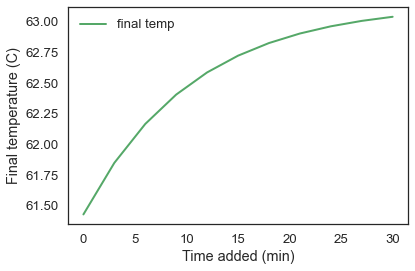

In [30]:
plot(sweep, label='final temp', color='C2')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)')

### 分析
我们再仔细看一下牛顿冷却定律这个公式：
$${{dT}\over{dt}}=-r(T-T_a)$$
实际上这个微分方程是有解析解的，一般解为：
$$T(t)=C_1e^{-rt}+T_{env}$$
当$T(0)=T_{init}$时的特解为：
$$T_{env}+(-T_{env}+T_{init})e^{-rt}$$
我们观察到$T(t_{end})=T_{end}$，我们可以用特解来求解r。结果是：
$$r={{1\over{t_end}}log{T_{init}-T_{env}\over{T_{end}-T_{env}}}}$$


现在我们使用分析结果计算温度和时间之间的关系函数。下面的函数与run_simulation类似。

In [31]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
        
    system: System object
    
    returns: TimeFrame
    """
    T_env, r = system.T_env, system.r
    
    T_init = system.init.T    
    ts = linspace(0, system.t_end)
    
    T_array = T_env + (T_init - T_env) * exp(-r * ts)
    
    # to be consistent with run_simulation,
    # we put the array into a TimeFrame
    return TimeFrame(T_array, index=ts, columns=['T'])

将$t_{end}=30$、$T_{end}=70$、$T_{init}=90$、$T_{env}=22$代入上面公式，可以得到r的估计值为0.0116。，这就是r_tea2的理论值。

In [32]:
r_tea2 = 0.011610223142273859
tea2 = make_system(T_init=90, r=r_tea2, volume=300, t_end=30)

,values
init,T 90 dtype: int64
r,0.01161
volume,300
temp,90
t_0,0
t_end,30
dt,1
T_env,22


In [33]:
results = run_analysis(tea2)
T_final_analysis = get_last_value(results.T)

70.0

然后我们比较仿真的结果。

In [34]:
tea = make_system(T_init=90, r=r_tea, volume=300, t_end=30)
results = run_simulation(tea, update_func)
T_final_simulation = get_last_value(results.T)

69.99999985860761

两者除了一些舍入误差，基本是一致的。

In [35]:
T_final_analysis - T_final_simulation

1.4139239112864743e-07

### 练习


# Solution goes here


